# Introduction

This document outlines the process to analyze raw data from the Video Velocimeter (VIV). 

This part of the script outlines process to install all necessary packages and then introduce the two main classes that are used in the analysis of the VIV data.

## General Utility Functions

These are necessary packages and basic utility functions to run the script.

In [ ]:
from scipy import optimize #need for fmin function
from scipy.spatial import distance
from scipy import ndimage #for bwlabel

import subprocess
import time
import numpy as np
import math
import random
import cv2
from operator import add #this will be use for mapping
#matplotlib is for inline plotting only
import matplotlib.pyplot as plt

In [ ]:
def plotImg(img,gray=1):
    #plot the input image using matplotlib
    #size is set by default to be large enough to see in Jupyter
    width = 10
    height = 10
    plt.figure(figsize=(width, height))
    if gray:
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)
    plt.show()
    return

# Checks if a matrix is a valid rotation matrix.
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6

# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :
 
    assert(isRotationMatrix(R))
     
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

# Calculates Rotation Matrix given euler angles.
def eulerAnglesToRotationMatrix(theta) :
     
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         math.cos(theta[0]), -math.sin(theta[0]) ],
                    [0,         math.sin(theta[0]), math.cos(theta[0])  ]
                    ])
         
         
                     
    R_y = np.array([[math.cos(theta[1]),    0,      math.sin(theta[1])  ],
                    [0,                     1,      0                   ],
                    [-math.sin(theta[1]),   0,      math.cos(theta[1])  ]
                    ])
                 
    R_z = np.array([[math.cos(theta[2]),    -math.sin(theta[2]),    0],
                    [math.sin(theta[2]),    math.cos(theta[2]),     0],
                    [0,                     0,                      1]
                    ])
                     
                     
    R = np.dot(R_z, np.dot( R_y, R_x ))
 
    return R

def insertParticle(c,r,img):
    '''insert a particle locating at c with radius r into img
    position c is [vertical,horizontal] (row,col)'''
    c=list(map(int,np.round(c))) #just in case center point is not int
    stat = 0 #use to indicate whether the pixel is in image or not
    if c[0]<=img.shape[1]-1 and c[1]<=img.shape[0]-1 and c[0]>=0 and c[1]>=0:
        stat = 1 #is in the dimensions of img
        cv2.circle(img,tuple(c),r,255,-1) #255--> circle will be white; -1--> draw filled in circle 
    return img,stat

## OpenPIV Python

We need to install OpenPIV python package to our workspace with the following command. Then, test installation by importing all necessary packages.

In [ ]:
!pip install openpiv

In [ ]:
import openpiv.tools
import openpiv.pyprocess
import openpiv.scaling
import openpiv.validation
import openpiv.filters

## Particle Detection Class

This class is used for detecting particles in extracted frames and then save them as raw binary masks. 

In [ ]:
class particleAnalysis():
    def __init__(self,mode,folder,nImg=10,vidNum = 0,setNum=[1000,2000],totFrame = 10000):
        
        #select mode first
        #mode = 0 => video mode
        #m0de = 1 => burst shot mode
        self.mode= mode
        
        self.vidNum = vidNum
        self.folder = folder
        
        self.nImg = nImg #number of images to analyze at a time (to get one velocity)
        self.setNum = setNum #setNum = [frist set, last set] for still image
        self.totFrame = totFrame #total frames for video analysis, video analysis always start at frame 0
        
        #particle detection for left Image
        self.img = np.array([])
        self.centroid = np.array([])
        self.area = np.array([])
        self.ptc_cnt = 0
        
        
    def ptcDetect(self,convInt = 1):
        '''Detect particles in the given image. Use BW connected element to identify.
        The particle location is simply the centroid of each connected element.
        imgLR specifies left or right view. imgLR = 1 select left view. imgLR = 0 select right view.
        convInt=1 will output centroid in integers; use this for drawing purposes.'''

        #perform BW labeling
        label_im, ptc_cnt = ndimage.measurements.label(self.img) 

        #input is an image, non-zero element --> a feature, zero element --> background 
        #label_im: output integer array, where every unique feature from the image has its own unique label
        #ptc_cnt: how many objects were found 
        #initialize output arrays
        centroid = np.array([[0,0]]) 
        #makes matrix (2 cols, many rows) to store coordinates of centeroids in 
        area = np.zeros((1,ptc_cnt))[0] 
        #makes array of zeros? 1 row, many cols, currently filled w/zeros 
        for i in range(ptc_cnt): #for every particle 
            index = np.argwhere(label_im==i+1) #find the element of interest
            if convInt: #convert to integer pixels 
                row = int(np.round(np.mean(index[:,0]))) #find the row centroid
                col = int(np.round(np.mean(index[:,1]))) #find the column centroid
            else:
                row = np.mean(index[:,0])
                col = np.mean(index[:,1])
            ct = np.array([[col,row]]) 
            #makes a 1 row by 2 col matrix to store the centeroid (x,y) of the given particle 
            centroid = np.concatenate((centroid,ct),axis=0)
            #add this centeroid (ct) to the list of centroids for all the particles 
            area[i] = len(index) #measure size of a particle via the number of pixels it is 

        #store results in object
        self.ptc_cnt = ptc_cnt
        self.centroid = centroid[1:]
        self.area = area

        return True

    def centroidImage(self,c_size,filename):
        '''Convert the given BW image to centroid only.'''
        img10 = np.zeros(self.img.shape,dtype=np.uint8) 
        #make an image the same dimensions of the imput image with uint8 datatype  
        for cent in self.centroid:
            #add each centroid to the image with radius 4
            #print cent
            img10,stat = insertParticle(cent,c_size,img10)
            if not stat: #probably if particle is not in the range of the img dimensions 
                print("Error inserting particles")
        cv2.imwrite(filename,img10) #save the image 
        return True
    
    def convertBW(self,filename,C):
        '''Convert image to BW image with adaptive thresholding.
        C = offset in afaptive thresholding algorithm.'''
        widthA, heightA = self.img.shape 
        #used to calculate neighborhood size like done in Matlab adaptiveThresh (see below)
        nhwA = int(2*math.floor((widthA)/16)+1)
        nhhA = int(2*math.floor((heightA)/16)+1)
        #print nhw, nhh --> 91 and 161 
        meansA = cv2.blur(self.img, (7, 7))
        #thresh = (img>(means-C))*255 
        #^^^Adaptive thresholding for each pixel of the image, using the pixel's mean as the threshold vaule    

        threshA = cv2.adaptiveThreshold(meansA,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,min(nhwA,nhhA),C)
        # print(filename)
        cv2.imwrite(filename,threshA)
        return threshA
                
    def fullImageAnaylsis(self,C,imSize,vidOffset=0):
        '''Run full image analysis algorithm.
        For each view, there should be two image output: (1) raw BW image and (2) centroid image
        '''

        #first determine the number of iteration for each mode
        if self.mode == 0:
            totIter = int(self.totFrame/self.nImg) #for video, total frame/nImg per analysis
        else:
            totIter = self.setNum[1]-self.setNum[0]+1 #for still image, simply total set
        
        print(totIter)
        
        for j in range(totIter):
             #for keeping track of progress
            print('Set #: %d' %j)
            for i in range(self.nImg): #iterate through nImg per set
                
               
                #note that there has to be a folder called bw in the working folder to save
                #generated images
                if self.mode == 0:
                    name = self.folder+'video%.4dframe%.5d.jpg'%(self.vidNum,(self.nImg*j)+(i+1))
                    #print name
                    nameA = self.folder+'bw/bwA%.5d_%.2d.jpg'%((j),i) #for raw bw image
                    nameAcent = self.folder+'bw/bwA_c_%.5d_%.2d.jpg'%((j),i) #for centroid image
                    nameB = self.folder+'bw/bwB%.5d_%.2d.jpg'%((j),i)
                    nameBcent = self.folder+'bw/bwB_c_%.5d_%.2d.jpg'%((j),i)
                else:
                    name = self.folder+'img%.4d_%.2d.jpg'%(self.setNum[0]+j,i)
                    nameA = self.folder+'bw/bwA%.5d_%.2d.jpg'%(self.setNum[0]+j,i)
                    nameAcent = self.folder+'bw/bwA_c_%.5d_%.2d.jpg'%(self.setNum[0]+j,i)
                    nameB = self.folder+'bw/bwB%.5d_%.2d.jpg'%(self.setNum[0]+j,i)
                    nameBcent = self.folder+'bw/bwB_c_%.5d_%.2d.jpg'%(self.setNum[0]+j,i)

                img = cv2.imread(name, 0)

                #LEFT SIDE
                #crop image for left view first
                self.img = img[300:300+imSize,130:130+imSize] #cropping factor
                #perform adaptive thresholding
                threshA = self.convertBW(nameA,C)
                self.img = threshA
                #particle detection
                self.ptcDetect() 
                #redraw centriod image
                self.centroidImage(4,nameAcent)
                
                #write ptc count to file
                file = open(self.folder+'ptc_left','a')
                ptc_string = '%d\n'%(self.ptc_cnt)
                file.write(ptc_string)
                file.close()
                
                
                #RIGHT SIDE
                self.img = img[ 300:300+imSize,870:870+imSize]
                threshB = self.convertBW(nameB,C)
                self.img = threshB
                
                #particle detection
                self.ptcDetect() #1 for left side
                #redraw centriod image
                self.centroidImage(4,nameBcent)
                
                #write ptc count to file
                file = open(self.folder+'ptc_right','a')
                ptc_string = '%d\n'%(self.ptc_cnt)
                file.write(ptc_string)
                file.close()
                
        return True
        
    def reportPtcData(self,LR):
        '''Report particle data to csv files'''
        ptcFile = 'ptc_'+LR+'.csv'
        areaFile = 'area_'+LR+'.csv'
        
        #write ptc count to file
        file = open(self.folder+ptcFile,'a')
        ptc_string = '%d\n'%(self.ptc_cnt)
        file.write(ptc_string)
        file.close()
        
        #write ptc area to file
        file = open(self.folder+areaFile, 'a')
        np.savetxt(file, self.area, delimiter=",")
        file.close()
        
        return True
                
    def ptcCountAnalysis(self,C,imSize,vidOffset=0):
        '''Perform particle counting and report ptc count and areas in a file'''
                #first determine the number of iteration for each mode
        if self.mode == 0:
            totIter = int(self.totFrame/self.nImg) #for video, total frame/nImg per analysis
        else:
            totIter = self.setNum[1]-self.setNum[0]+1 #for still image, simply total set

        print(totIter)

        for j in range(totIter):
             #for keeping track of progress
            print('Set #: %d' %j)
            for i in range(1): #iterate only 1 sample per set to save time

                if self.mode == 0:
                    name = self.folder+'video%.4dframe%.6d.jpg'%(self.vidNum,(self.nImg*j)+(i+1)+vidOffset)
                    #print name
                    nameA = self.folder+'bw/bwA%.6d_%.2d.jpg'%((j),i) #for raw bw image
                    nameAcent = self.folder+'bw/bwA_c_%.6d_%.2d.jpg'%((j),i) #for centroid image
                    nameB = self.folder+'bw/bwB%.6d_%.2d.jpg'%((j),i)
                    nameBcent = self.folder+'bw/bwB_c_%.6d_%.2d.jpg'%((j),i)
                else:
                    name = self.folder+'img%.4d_%.2d.jpg'%(self.setNum[0]+j,i)
                    nameA = self.folder+'bw/bwA%.5d_%.2d.jpg'%(self.setNum[0]+j,i)
                    nameAcent = self.folder+'bw/bwA_c_%.5d_%.2d.jpg'%(self.setNum[0]+j,i)
                    nameB = self.folder+'bw/bwB%.5d_%.2d.jpg'%(self.setNum[0]+j,i)
                    nameBcent = self.folder+'bw/bwB_c_%.5d_%.2d.jpg'%(self.setNum[0]+j,i)

                #print name
                img = cv2.imread(name, 0)

                #LEFT SIDE
                #crop image for left view first
                self.img = img[300:300+imSize,130:130+imSize] #cropping factor
                #cv2.imwrite(self.folder+'bw2/left.jpg',self.img)
                #perform adaptive thresholding
                threshA = self.convertBW(nameA,C)
                self.img = threshA
                #particle detection
                self.ptcDetect() 
                #write ptc data to files
                self.reportPtcData('left')
                
                



                #RIGHT SIDE
                self.img = img[ 300:300+imSize,870:870+imSize]
                #cv2.imwrite(self.folder+'bw2/left.jpg',self.img)
                threshB = self.convertBW(nameB,C)
                self.img = threshB

                #particle detection
                self.ptcDetect() #1 for left side
                #write ptc data to files
                self.reportPtcData('right')
                
                #cv2.imwrite(self.folder+'bw2/right.jpg',self.img)

        return True
        

## PIV Analysis Class

This class is used to perform particle image velocimetry analysis using OpenPIV package.

In [ ]:
def outlierFilter(data,nSD):
    '''Remove any outliers that are beyond median+\-n*SD'''
    sigma = nSD*np.std(data)
    #mu = np.median(data)
    mu = np.mean(data)
    return data[(data<mu+sigma)&(data>mu-sigma)]

class pivAnalysis:
    def __init__(self,folder,angle,mode=0,nImg=10,window_size=100,dt=1.0/65,setNum=[1000,2000],snr_method='peak2peak',plot=0):
        #basic parameters
        self.plot = plot
        self.folder = folder
        self.nImg = nImg
        self.setNum = setNum
        #mode = 0 => video mode
        #mode = 1 => burst shot mode
        self.mode = mode
        
        #parameters for PIV
        self.window_size = window_size
        self.overlap = int(self.window_size/2)
        self.dt = dt
        self.search_area_size = self.window_size
        
        #image names
        self.frame_1 = np.array([])
        self.frame_2 = np.array([])
        
        #storing results of PIV
        self.u0 = np.array([]) #raw u,v output from PIV
        self.v0 = np.array([])
        self.piv_disX_a = np.array([]) #accumulation from sequence for left view
        self.piv_disY_a = np.array([])
        self.piv_disX_b = np.array([]) #accumulation from sequence for right view
        self.piv_disY_b = np.array([])
        self.u1x = 0 #mean from left camera
        self.v1y = 0
        self.u2x = 0 #mean from right camera
        self.v2y = 0
        self.velocity = np.array([1.0,1.0,1.0]) #final 3d velocity
        self.velArray = np.array([[0,0,0]]) #for accumulating all results
        #stereo parameters
        #note that angle is in the form [theta_x,theta_y,theta_z] in radians
        self.angle = angle
        
        #for error analysus
        self.snr_method = snr_method
        self.snr0 = np.array([])
        self.snr_array_a = np.array([])
        self.snr_array_b = np.array([])
        
    def updateFrame(self,LR,curSet,iIm):
        '''Update the current image name in analysis'''
        name1 = self.folder+ 'bw' + LR + '%.5d_%.2d.jpg' %(curSet,iIm)
        name2 = self.folder+ 'bw' + LR + '%.5d_%.2d.jpg' %(curSet,iIm+1)
#         name1 = self.folder+ 'bw' + LR + '_c_%.6d_%.2d.jpg' %(curSet,iIm)
#         name2 = self.folder+ 'bw' + LR + '_c_%.6d_%.2d.jpg' %(curSet,iIm+1)
        frame_a  = openpiv.tools.imread( name1 )
        frame_b  = openpiv.tools.imread(name2 )
        #change data type to int32
        self.frame_1 = frame_a.astype(np.int32)
        self.frame_2 = frame_b.astype(np.int32)
        return
       
    def PIVcalc(self):
        '''Perform a PIV analysis on the two consecutive images.'''
        #perform PIV analysis
        u0, v0, sig2noise = openpiv.pyprocess.extended_search_area_piv( self.frame_1, self.frame_2, self.window_size, self.overlap, self.dt, self.search_area_size, sig2noise_method=self.snr_method,width=50 )
        #store output; note that dt is multiplied to convert from speed to displacement
        self.u0 = u0.reshape(-1)*self.dt 
        self.v0 = v0.reshape(-1)*self.dt
        self.snr0 = sig2noise.reshape(-1)
        return u0,v0
    
    def pivSequence(self,LR,curSet):
        piv_disX = np.array([]) #array for piv displacement
        piv_disY = np.array([]) #array for piv displacement
        snr = np.array([])
        for i in range(self.nImg-1):
            self.updateFrame(LR,curSet,i) #update frames 
            self.PIVcalc() #perform PIV calculation
            piv_disX = np.append(piv_disX,self.u0) #append result to arrays
            piv_disY = np.append(piv_disY,self.v0)
            snr = np.append(snr,self.snr0)
        if self.plot:
            plt.hist(piv_disX,bins=25)
            #plt.hist(piv_disX,bins=10)
            plt.xlabel('Displacement (pixels)')
            plt.title('Vx')
            #figName = 'histX%.2d.png' %save
            #figName = folder+figName
            #print figName
            #plt.savefig(figName)
            plt.show()
            
            plt.hist(piv_disY,bins=25)
            #plt.hist(piv_disY,bins=10)
            plt.xlabel('Displacement (pixels)')
            plt.title('Vy')
            #figName = 'histY%.2d.png' %save
            #figName = folder+figName
            #plt.savefig(figName)
            plt.show()
            
            plt.hist(snr,bins=25)
            #plt.hist(piv_disY,bins=10)
            plt.xlabel('SNR (dB)')
            plt.title('SNR')
            #figName = 'histY%.2d.png' %save
            #figName = folder+figName
            #plt.savefig(figName)
            plt.show()
            
        if LR=='A':
            self.piv_disX_a = piv_disX
            self.piv_disY_a = piv_disY
            self.snr_array_a = snr
        else:
            self.piv_disX_b = piv_disX
            self.piv_disY_b = piv_disY
            self.snr_array_b = snr
        
        return piv_disX,piv_disY
    
    def recordData(self):
        '''Record result to a txt file for future use.'''
        file = open(self.folder+'rawPIV.csv','a')
        #print((self.piv_disX_a,self.piv_disY_a,self.piv_disX_b,self.piv_disY_b,self.snr_array_a,self.snr_array_b))
        pivXY = np.column_stack((self.piv_disX_a,self.piv_disY_a,self.piv_disX_b,self.piv_disY_b,self.snr_array_a,self.snr_array_b)) 
        np.savetxt(file,pivXY,delimiter=',')
        file.close()
        
        file = open(self.folder+'meanPIV.csv','a')
        pivXY = '%f,%f,%f,%f\n'%(self.u1x,self.v1y,self.u2x,self.v2y)
        file.write(pivXY)
        file.close()
        
        return True
        
        
        
    def pivStereo(self,curSet):
        '''Perform stereo PIV'''
        #left view
        self.pivSequence('A',curSet)
        leftX = outlierFilter(self.piv_disX_a,1) #filter outlier
        leftY = outlierFilter(self.piv_disY_a,1)
        self.u1x = np.mean(leftX)
        self.v1y = np.mean(leftY)
        
        #right view
        self.pivSequence('B',curSet)
        leftX = outlierFilter(self.piv_disX_b,1) #filter outlier
        leftY = outlierFilter(self.piv_disY_b,1)
        self.u2x = np.mean(leftX)
        self.v2y = np.mean(leftY)
        
        self.recordData() #write raw results to csv files
        
        #stereo calculation
        #first find rotation matrix of each camera
        R_left = eulerAnglesToRotationMatrix(self.angle/2.0)
        R_right = eulerAnglesToRotationMatrix(-self.angle/2.0)
        #stack rotation matrices
        rMat = np.concatenate((R_left[[0,1],:],R_right[[0,1],:]),axis=0)
        #inverse matrix
        p = 1.0 #scaling factor
        pMat = np.array([self.u1x/p,self.v1y/p,self.u2x/p,self.v2y/p])
        self.velocity = np.linalg.lstsq(rMat,pMat)[0]
        return self.velocity

    def fullSetAnalysis(self):
        '''Perform stereo analysis of the full set'''
        for i in range(self.setNum[0],self.setNum[1]+1): #iterate over all sets
            #for keeping track of progress
            print('Set %d' %i)
            
            self.pivStereo(i)
            self.velArray = np.concatenate((self.velArray,[self.velocity]),axis=0)
        return True

# Data Analysis

The overall process to analyze raw data is as follow.
<ol>
  <li>The raw data from the VIV are saved in raw h264 video file.</li>
  <li>Extract individual frames from the raw file using an appropriate programs. A recommended program is FFMPEG, which can be run using command lines. An example FFMPEG command line is [ffmpeg -i input.mp4 -qscale:v 2 output_%03d.jpg]. For further information, consult this <a href="https://stackoverflow.com/questions/10225403/how-can-i-extract-a-good-quality-jpeg-image-from-a-video-file-with-ffmpeg">discussion</a>.</li>
  <li>Run particle detection algorithm.</li>
    <li>Run particle image velocimetry algorithm.</li>
</ol>

## Data Handling

First, we need to transfer the raw data from our Google Drive folder to the current Colab workspace. We start by mounting our Google Drive to the current workspace.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Then, transfer the raw video file to the workspace.

In [ ]:
data_folder = "/content/gdrive/Shareddrives/VIV_Applications/Data/"
filename = "video0000.h264"

In [ ]:
copy_cmd = 'cp %s%s /content/%s'%(data_folder,filename,filename)
print(copy_cmd.split(" "))
start_t = time.time()
subprocess.check_output(copy_cmd.split(" "))
end_t = time.time()
print("Finished copying files in %.2f s."%(end_t-start_t))

['cp', '/content/gdrive/Shareddrives/VIV_Applications/Data/video0000.h264', '/content/video0000.h264']
Finished copying files in 5.89 s.


Now run the FFMPEG command to extract frames from the raw data. 

In [ ]:
!mkdir images
!ffmpeg -i video0000.h264 -qscale:v 2 images/video0001frame%05d.jpg

## Particle Detection

We now perform the particle detection algorithm. This process will run adaptive thresholding algorithm on to the extracted frames. Then, the resulting binary masks are saved as separated image files in a subfolder called **bw**. We have to first create the subfolder in the data directory. 

In [ ]:
!mkdir images/bw/

This particle detection algorithm takes a long time to run because it saves resulting masks as image files. This process should be optimized in the future such that no saving is needed.

In [ ]:
ptc = particleAnalysis(0,'images/',vidNum=1,totFrame=13900)
ptc.fullImageAnaylsis(-3,400)

## PIV Analysis

Now that we have the binary masks of particles, we can finally do the particle image velocimetry analysis. 

In [ ]:
#second run to save all results in txt file
theta = np.array([ -5.75852669,  72.35917543,  -7.94223563]) #angles from calibration
theta = theta*np.pi/180 #convert to radians

piv = pivAnalysis('images/bw/',angle = theta,window_size=400,setNum = [0,1389],plot=0)
piv.fullSetAnalysis()

The final result is the 3D velocity stored in the object `piv` and can be called with `piv.velArray`. This code block below shows an example of how to plot the result.

The result is in the unit of pixel/s. It has to be scaled to mm/s by multiplying with the scaling factor from calibration (the varaible M from the equation in the paper). For this VIV, we use `M=3.6`. The plot will show the result in mm/s. 

However, the x-axis is still in frame (not seconds). We can convert frame to seconds by multiplying by the time between frames. Since the frame rate is 65 fps, multiplying the frame number by 1/65 will give the x axis in seconds. 

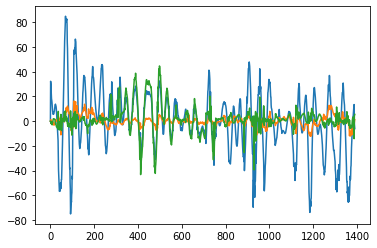

<Figure size 1440x1440 with 0 Axes>

In [ ]:
scale = 3.6
plt.plot(piv.velArray*scale)
width = 20
height = 20
plt.figure(figsize=(width, height))
plt.show()